NCGNN: Node Classifier Graph Neural Network, A Simple Example of Node Classification with GNN
There are two special properties we are dealing with in this example:
- We have one large graph and not many individual graphs (like molecules)
- We infere on unlabeled nodes in this large graph and hence perform node-level predictions --> We have to use different nodes of the graph depending on what we want to do

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [4]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]  

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


Observations:
- We only have a relatively small set of training nodes (20 nodes per class)
- There are binary test, train and validation masks of the size #nodes (they tell use which node can be used for which task)

In [5]:
print(data.x.shape) # [No. Nodes x Features]

# Print some of the normalized word counts of the first datapoint
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

Why do we even use the graph structure - aren't the features enough? Apparently, simple MLP models perform a lot worse than GNNs on this type of task, as the citation information is crucial for a correct classification.

In [6]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [7]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

Which nodes will be used during training are displayed in data.test_mask.

In [8]:
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [9]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


Observations:
- Dropout is only applied in the training step, but not for predictions
- We have 2 Message Passing Layers and one Linear output layer
- We use the softmax function for the classification problem
- The output of the model are 7 probabilities, one for each class

Just a reminder:
Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass. In other words, dropout is created as a regularization technique that we can use to reduce the model capacity so that our model can achieve lower generalization error.

In [10]:
# Initialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4 #The decay parameter in Adam optimizer is used to reduce the learning rate over time to converge faster and avoid overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with 
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad() 
      # Use all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)  
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)  
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.8616
Epoch: 200, Loss: 1.7218
Epoch: 300, Loss: 1.6939
Epoch: 400, Loss: 1.6404
Epoch: 500, Loss: 1.5370
Epoch: 600, Loss: 1.4868
Epoch: 700, Loss: 1.4564
Epoch: 800, Loss: 1.3921
Epoch: 900, Loss: 1.3838
Epoch: 1000, Loss: 1.3424


<Axes: >

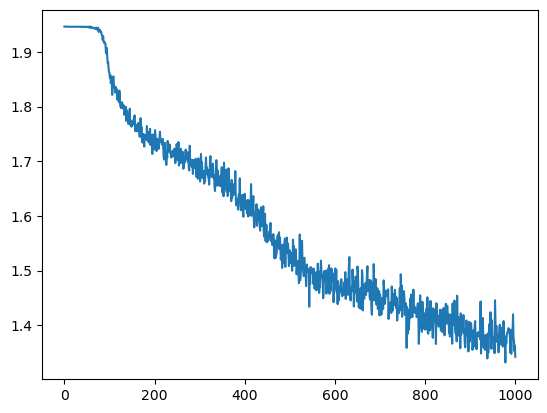

In [14]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(x=loss_indices, y=losses_float)
plt

In [15]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7370


torch.Size([2708, 7])


<Axes: >

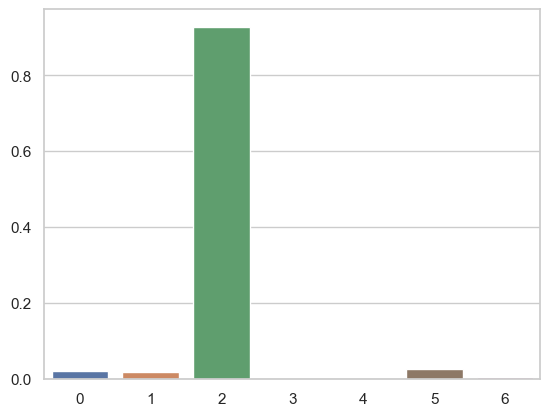

In [16]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())